# Comparison with 1990

Here, we test cleaning up lines by finding lines that match the 1990 digitized maps and lines that dont match.

In [3]:
import geopandas as gpd
from shapely.geometry import LineString
from shapely.strtree import STRtree
import os
import matplotlib.pyplot as plt


In [4]:
# Break polygon boundaries down into individual line segments
def extract_lines_from_polygons(gdf, min_length=1.0):
    lines = []
    
    for idx, row in gdf.iterrows():
        geom = row.geometry
        if geom.geom_type == 'Polygon':
            # Get outline
            exterior_coords = list(geom.exterior.coords)
            # Make line segments between each point
            for i in range(len(exterior_coords) - 1):
                line = LineString([exterior_coords[i], exterior_coords[i + 1]])
                if line.length >= min_length:  
                    lines.append({
                        'geometry': line,
                        'source_polygon': idx,
                        'length': line.length
                    })
        elif geom.geom_type == 'MultiPolygon':
            for poly in geom.geoms:
                exterior_coords = list(poly.exterior.coords)
                for i in range(len(exterior_coords) - 1):
                    line = LineString([exterior_coords[i], exterior_coords[i + 1]])
                    if line.length >= min_length:
                        lines.append({
                            'geometry': line,
                            'source_polygon': idx,
                            'length': line.length
                        })
    
    return gpd.GeoDataFrame(lines, crs=gdf.crs)

# Find matching and non-matching lines between two polygon datasets and save
def compare_boundaries(uncleaned, map_1990, output_dir, buffer_distance=10.0, min_line_length=2.0):
    gdf_uncleaned = gpd.read_file(uncleaned)
    gdf_1990 = gpd.read_file(map_1990)
    
    # Make sure coordinate systems match
    if gdf_uncleaned.crs != gdf_1990.crs:
        gdf_1990 = gdf_1990.to_crs(gdf_uncleaned.crs)

    
    # Extract lines from both datasets
    lines_uncleaned = extract_lines_from_polygons(gdf_uncleaned, min_line_length)
    
    lines_1990 = extract_lines_from_polygons(gdf_1990, min_line_length)
    
    # Buffer the 1990 lines
    buffered_1990 = lines_1990.geometry.buffer(buffer_distance)
    
    # Make a spatial index for fast lookups
    spatial_index = STRtree(buffered_1990)
    
    # Check each uncleaned line
    non_matching_indices = []
    matching_indices = []
    
    for idx, row in lines_uncleaned.iterrows():
        line_uncleaned = row.geometry
        
        # Use spatial index to find potential matches quickly
        potential_matches = list(spatial_index.query(line_uncleaned))
        
        # Check if any potential match actually intersects
        intersects = any(line_uncleaned.intersects(buffered_1990.iloc[match_idx]) 
                       for match_idx in potential_matches)
        
        if intersects:
            matching_indices.append(idx)
        else:
            non_matching_indices.append(idx)
    
    non_matching_lines = lines_uncleaned.loc[non_matching_indices].copy()
    matching_lines = lines_uncleaned.loc[matching_indices].copy()

    
    # Save results
    os.makedirs(output_dir, exist_ok=True)
    
    non_matching_lines.to_file(os.path.join(output_dir, "non_matching_lines.shp"))
    matching_lines.to_file(os.path.join(output_dir, "matching_lines.shp"))
    
    return non_matching_lines, matching_lines


In [5]:
# File paths
uncleaned_map = "../outputs/outputs_1977/77KN5142_Poly_cropped.shp"
map_1990 = "../kern_1990/i15_LandUse_Kern1990.shp"
output_dir = "filtered_boundaries/"

compare_boundaries(uncleaned_map, map_1990, output_dir)



Found 73159 non-matching lines
Found 17327 matching lines


/tmp/ipykernel_629021/3194062176.py:82: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  non_matching_lines.to_file(os.path.join(output_dir, "non_matching_lines.shp"))
/Users/jcardelle/.conda/envs/ag_lab/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'source_polygon' to 'source_pol'
  ogr_write(
/tmp/ipykernel_629021/3194062176.py:83: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  matching_lines.to_file(os.path.join(output_dir, "matching_lines.shp"))
/Users/jcardelle/.conda/envs/ag_lab/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'source_polygon' to 'source_pol'
  ogr_write(


(                                                geometry  source_polygon  \
 0      LINESTRING (-4738.068 13812.252, -4738.068 138...               0   
 5      LINESTRING (-4697.983 13830.445, -4700.773 138...               0   
 6      LINESTRING (-4701.007 13827.09, -4701.007 1375...               0   
 7      LINESTRING (-4700.876 13751.278, -4695.459 137...               0   
 8      LINESTRING (-4694.828 13742.648, -4688.875 137...               0   
 ...                                                  ...             ...   
 90478  LINESTRING (-2441.197 115.225, -2438.408 112.436)            1615   
 90479  LINESTRING (-2437.842 112.202, -2435.155 112.202)            1615   
 90480  LINESTRING (-2435.122 112.188, -2432.303 109.369)            1615   
 90481   LINESTRING (-2431.81 109.138, -2428.776 108.862)            1615   
 90482    LINESTRING (-2428.757 108.84, -2428.757 15.021)            1615   
 
           length  
 0      12.112199  
 5       3.945043  
 6      75.374

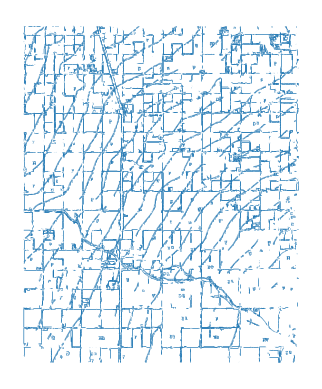

In [13]:
# Plot non matching lines
gdf_nonmatching = gpd.read_file("filtered_boundaries/test/non_matching_lines.shp")
gdf_nonmatching.plot(linewidth=0.5)
plt.axis('off')
plt.show()

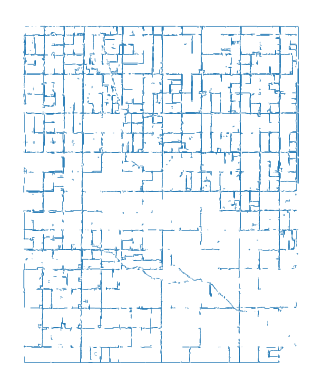

In [12]:
# Plot matching lines
gdf_matching = gpd.read_file("filtered_boundaries/test/matching_lines.shp")
gdf_matching.plot(linewidth=0.5)
plt.axis('off')
plt.show()